# Event Queue Application Benchmarks

In [12]:
# select measurement file
files = [
    "../output/2025-03-05 13-20-54 queue.json"
]

# plot settings
show_error_bar = False
unit = "ms"

In [13]:
# parse data
import json

raw_data = []
for file_name in files:
    with open(file_name) as file:
        raw_data.extend(json.load(file))

In [14]:
from util.convert import convert_datasets
import pandas as pd

ram = convert_datasets(
    raw_data,
    "Event Queue",
    [("event_queue_ram", "RAM Buffer")],
    [
        "mean",
        "min",
        "max",
        "options.object_size",
        "options.queue_length",
        "options.iterations",
        "options.buffer_size",
        "options.ram_overhead",
        "machine_name",
        "cold_start",
        "repetitions",
    ],
    unwrapped=show_error_bar,
)

storage = convert_datasets(
    raw_data,
    "Event Queue",
    [("event_queue_storage", "Storage")],
    [
        "mean",
        "min",
        "max",
        "options.object_size",
        "options.queue_length",
        "options.iterations",
        "options.buffer_size",
        "options.ram_overhead",
        "machine_name",
        "cold_start",
        "repetitions",
    ],
    unwrapped=show_error_bar,
)
vnvheap = convert_datasets(
    raw_data,
    "Event Queue",
    [("event_queue", "vNV-Heap")],
    [
        "mean",
        "min",
        "max",
        "options.object_size",
        "options.queue_length",
        "options.iterations",
        "options.buffer_size",
        "options.ram_overhead",
        "machine_name",
        "cold_start",
        "repetitions",
    ],
    unwrapped=show_error_bar,
)

dataset = pd.concat([ram, storage, vnvheap])
assert dataset["options.iterations"].nunique() == 1
dataset["mean"] = dataset["mean"] / dataset["options.iterations"].iloc[0]
dataset["min"] = dataset["min"] / dataset["options.iterations"].iloc[0]
dataset["max"] = dataset["max"] / dataset["options.iterations"].iloc[0]

dataset.head()

[{'mean': 9238841.0, 'min': 9238841, 'max': 9238841, 'options.object_size': 256, 'options.queue_length': 0, 'options.iterations': 10000, 'options.buffer_size': 256, 'options.ram_overhead': 16, 'bench_name': 'event_queue_ram', 'machine_name': 'esp32c3', 'cold_start': 0, 'repetitions': 1, 'ticks_per_ms': 16000}, {'mean': 9238841.0, 'min': 9238841, 'max': 9238841, 'options.object_size': 256, 'options.queue_length': 1, 'options.iterations': 10000, 'options.buffer_size': 512, 'options.ram_overhead': 16, 'bench_name': 'event_queue_ram', 'machine_name': 'esp32c3', 'cold_start': 0, 'repetitions': 1, 'ticks_per_ms': 16000}, {'mean': 9238841.0, 'min': 9238841, 'max': 9238841, 'options.object_size': 256, 'options.queue_length': 2, 'options.iterations': 10000, 'options.buffer_size': 768, 'options.ram_overhead': 16, 'bench_name': 'event_queue_ram', 'machine_name': 'esp32c3', 'cold_start': 0, 'repetitions': 1, 'ticks_per_ms': 16000}, {'mean': 9238841.0, 'min': 9238841, 'max': 9238841, 'options.objec

,mean,min,max,options.object_size,options.queue_length,options.iterations,options.buffer_size,options.ram_overhead,machine_name,cold_start,repetitions,ticks_per_ms,dataset_type,benchmark_title,benchmark_id
0,923.8841,923.8841,923.8841,256,0,10000,256.0,16,esp32c3,0,1,16000,Event Queue,RAM Buffer,event_queue_ram
1,923.8841,923.8841,923.8841,256,1,10000,512.0,16,esp32c3,0,1,16000,Event Queue,RAM Buffer,event_queue_ram
2,923.8841,923.8841,923.8841,256,2,10000,768.0,16,esp32c3,0,1,16000,Event Queue,RAM Buffer,event_queue_ram
3,923.8841,923.8841,923.8841,256,3,10000,1024.0,16,esp32c3,0,1,16000,Event Queue,RAM Buffer,event_queue_ram
4,923.8841,923.8841,923.8841,256,4,10000,1280.0,16,esp32c3,0,1,16000,Event Queue,RAM Buffer,event_queue_ram


In [15]:
from util.convert import display_dataset_infos

display_dataset_infos(dataset)

min    57.742756
max    57.742762
Name: mean, dtype: float64

min    7981.434337
max    7981.467156
Name: mean, dtype: float64

min      77.648925
max    8384.886850
Name: mean, dtype: float64

# Final Plot

vNV-Heaps latency jump happens after 12
Max buffer size: 4096.0
Max queue size for "Only RAM": 14


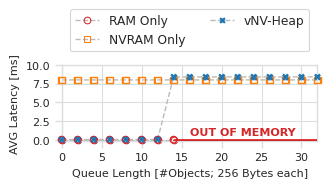

In [16]:
from util.plot import plot_lines, save_plot, plot_colors
from util.convert import scale_data
import numpy as np

scale = 2
norm = False

impl_data = dataset[(dataset["benchmark_id"] == "event_queue")]

prev_mean = -1
for mean in impl_data["mean"]:
    if prev_mean != -1:
        if mean > prev_mean * 2:
            break

    prev_mean = mean
    
print("vNV-Heaps latency jump happens after", impl_data[impl_data["mean"] == prev_mean]["options.queue_length"].max())

impl_data = impl_data[(impl_data["options.queue_length"] % scale == 0)]

assert len(impl_data["options.buffer_size"].unique()) == 1
assert len(impl_data["options.ram_overhead"].unique()) == 1

max_buffer_size = (
    impl_data["options.buffer_size"][0] + impl_data["options.ram_overhead"][0]
)
print("Max buffer size:", max_buffer_size)

ram_data = dataset[
    (dataset["benchmark_id"] == "event_queue_ram")
]
ram_data = ram_data[
    (ram_data["options.buffer_size"] + ram_data["options.ram_overhead"])
    <= max_buffer_size
]

print("Max queue size for \"Only RAM\":", ram_data[ram_data["benchmark_id"] == "event_queue_ram"]["options.queue_length"].max())

ram_data = ram_data[(ram_data["options.queue_length"] % scale == 0)]



plot_data = [
    {
        "name": "RAM Only",
        "x": "options.queue_length",
        "y": "mean",
        "marker": "o",
        "use_edge_color": True,
        "data": ram_data,
    },
    {
        "name": "NVRAM Only",
        "x": "options.queue_length",
        "y": "mean",
        "marker": "s",
        "use_edge_color": True,
        "data": dataset[
            (dataset["benchmark_id"] == "event_queue_storage")
            & (dataset["options.queue_length"] % scale == 0)
        ],
    },
    {
        "name": "vNV-Heap",
        "x": "options.queue_length",
        "y": "mean",
        "marker": "X",
        "data": impl_data,
    },
]

obj_size = dataset["options.object_size"].unique()[0]

norm_val = None
if norm:
    ram_data_tmp = scale_data(ram_data, unit)
    norm_val = ram_data_tmp["mean"].mean()

options = {
    "data": plot_data,
    "scale": unit,
    "x_label": f"Queue Length [#Objects; {obj_size} Bytes each]",
    "y_label": f"AVG Latency [{unit}]" if not norm else "Latency [Norm.]",
#    "norm": norm_val,
    "height": 0.3
}

ram_data_tmp = ram_data.copy()
ram_data_tmp = scale_data(ram_data, unit)

axes = plot_lines(options)
ax = axes[0]
plot_y = ram_data_tmp.iloc[-1]["mean"]
if norm:
    plot_y /= norm_val

ax.plot(
    [
        ram_data_tmp["options.queue_length"].max(),
        impl_data["options.queue_length"].max(),
    ],
    [plot_y, plot_y],
    color=plot_colors["baseline"],
    linewidth=2,
    zorder=3
)
text_x = (ram_data_tmp["options.queue_length"].max() + impl_data["options.queue_length"].max()) / 2
text_x = text_x - text_x*0.3
text_y = ram_data_tmp.iloc[-1]["mean"] + ram_data_tmp.iloc[-1]["mean"]*2
if norm:
    text_y /= norm_val

ax.text(text_x, text_y * 4, "OUT OF MEMORY", weight="bold", color=plot_colors["baseline"])
ax.legend(
    loc = "lower center",
    bbox_to_anchor=(0.5, 1.1),
    ncol=2,
    title=None,
    frameon=True
)
if norm:
    ax.set_xticks([0,5,10,15,20,25,30])
    ax.set_yticks([0,50,100,150])
    ax.set_xlim(right=32)
else:
    ax.set_xticks([0,5,10,15,20,25,30])
    ax.set_yticks([0,2.5,5,7.5,10])
    ax.set_xlim(right=32)
ax.set_ylim(bottom=-0.1)


save_plot("queue", False)